# **RUBIK'S CUBE SOLVER** 🧊
## *Cavicchioli Maria Vittoria - Cervesato Rossana*
---
This project, developed in python, is composed of two parts:

1. Colors and positions extraction of Rubik's cube faces


> INPUT:  six Rubik's cube faces (photos) ---> OUTPUT: ordered sequence of colors

2. Rubik's cube solver

> INPUT: ordered sequence of colors ---> OUTPUT: ordered sequence of moves to solve the cube



**Input Rubik's faces**

<img src="https://i.ibb.co/bmW2GYx/faces.png" alt="faces" border="0" width="500" height="auto">

                                      🔽

**Color map**

The configuration string of the cube corresponds to the color of the stickers according to the following figure:

```
                              Or Wh Wh
                              Bl Gr Gr
                              Bl Gr Ye
                    Wh Or Ye  Or Re Gr  Or Or Bl  Or Or Gr
                    Gr Re Gr  Wh Wh Wh  Bl Or Bl  Ye Ye Ye
                    Ye Ye Ye  Gr Re Gr  Wh Wh Wh  Bl Or Bl
                              Rd Bl Rd
                              Rd Bl Rd
                              Rd Ye Rd
```
Note that the back side is mirrored in the horizontal axis during unfolding.

Each 'sticker' must be a single character.

**Color map in string format** (row by row of previous map):  `OWWBGGBGYWOYORGOOBOOGGRGWWWBOBYYYYYYGRGWWWBOBRBRRBRRYR`

                                      🔽

**Ordered sequence of moves to solve the cube**

Bi E L Ei Li 2 B 2 R L B Li Mi D M Di R B Ri...

---








## **TERMINOLOGY**
**FACE** = one of the six sides of the Rubik's cube

*   **F** = front 
*   **B** = back
*   **D** = bottom
*   **U** = top
*   **L** = left
*   **R** = right



<img src="https://i.ibb.co/tBNh01c/3x-Cube-Notation01.gif" alt="3x-Cube-Notation01" border="0" width="200" height="auto">
<img src="https://i.ibb.co/5cYyqZb/download.png" alt="download" border="0" width="140" height="auto">


**SQUARE** = one of the nine squares in a cube face

<img src="https://i.ibb.co/bFmT6Gc/3x3grid.png" alt="3x3grid" border="0" width="200" height="auto">


**MOVES**

Each letter represents a clockwise 1/4 rotation. An “i” represents its counter-clockwise rotation.

<img src="https://i.ibb.co/LZhBF8L/rotations.png" alt="rotations" border="0">

In addition to a letter, each move may be forerun by the number two meaning turn that face 180 degrees (direction is irrelevant).

Rotations of the entire cube are simply identified through the x-y-z axes (e.g., X is a clockwise rotation of the entire cube around the positive x-axis).

## **PART 1: colors and positions extraction of Rubik's cube faces**

For this part two methods are proposed. In both methods, for each face, the code extract the ordered sequence of colors and stores it in a dictionary that will be later used to create the "row-by-row" input needed in the second part.

*Note: to run this code you need to upload in **your** google drive the six cube's faces pictures in a folder called "rubik" and allow the program to access them*

In [ ]:
import cv2
import numpy as np
import math
from imutils import contours
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### **COMMON CODE TO BOTH METHODS**

Color ranges, defined by the user depending on the cube's colors.

<img src="https://i.ibb.co/rtrWVxp/HSV-color-solid-cylinder-alpha-lowgamma.png" alt="HSV-color-solid-cylinder-alpha-lowgamma" border="0" width="300" height="auto">

In [ ]:
# blue
low_B = np.array([100,170,0])
up_B = np.array([140,255,255])

# red
low_R = np.array([170,140,0])
up_R = np.array([180,255,255])

# yellow
low_Y = np.array([25,140,0])
up_Y = np.array([35,255,255])

# green
low_G = np.array([40,140,0])
up_G = np.array([75,255,255])

# orange
low_O = np.array([0,140,0])
up_O = np.array([20,255,255])

# white
low_W = np.array([0,0,128])
up_W = np.array([180,60,255])

col_names = ["B", "R", "Y", "G", "O", "W"]


`extractColor` function takes in input and image, a color name, and a integer (iter) that will control the "strength" of the smoothing step.

Given the image, mapped to the hsv color space, the function is able to create a binary mask where the white areas correspond to areas in the image where the input color is present.

In [ ]:
def extractColor(color, img, iter):
  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  if color == "black":
    low = np.array([0, 0, 0])
    up = np.array([180, 255, 85])
  else:    
    low = eval("low_"+color)
    up = eval("up_"+color)

  # pop out the color from the image
  mask_color = cv2.inRange(hsv_img, low, up)

  # remove noise, make it more smooth
  rect =cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
  mask_color = cv2.erode(mask_color, rect)
  mask_color = cv2.dilate(mask_color, rect, iterations = iter)

  return mask_color

`removeBG` removes the uniform background of the Rubik's cube photo

In [ ]:
def removeBG(img):
  # setting black range to pop out the black grid of the cube face
  grid = extractColor("black", img, iter = 3)

  # extract outer contour of the face
  cnts, _ = cv2.findContours(grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # prepare black background
  bg = np.zeros(img.shape[:2], np.uint8)
  cv2.drawContours(bg, cnts, -1, 255, -1)

  # remove bakground from original photo
  final_img = cv2.bitwise_and(img, img, mask = bg)

  return final_img

<img src="https://i.ibb.co/V34q71Q/download-1.png" alt="download-1" border="0">

### **Method A**

**Workflow**

1. Isolate the cube's face by background removal
2. Extract the nine face's squares in a binary image
3. Draw contours of the nine squares
4. Compute centroids of each contour
5. Given (x,y) coordinates of centroids, sort them from top-to-bottom and from left-to-right
6. Mask the nine squares for a single color in a binary image, draw contours, and compute centroids
7. Compare just found centroids with the reference ones and retrieve the color position among the nine squares
8. Repeat for each color

`centroids` function takes in input a binary image where all (or some of) the squares in a face are highlithed. Given the image, this function extract contours of the squares and computes the central point (centroid) of the area of each contour. 

In [ ]:
def centroids(squares): 
  # extract square contours
  cnts, _ = cv2.findContours(squares, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # store (x,y) coordinates of all square centroids
  centroids = []

  for c in cnts:
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX,cY))
    cv2.circle(squares, (cX, cY), 10, 0, 30)
  return centroids

`compare` function calculates the distance between the centroids computed for the whole set of nine squares with each centroid computed from color-based masked squares. Once it finds the closest centroid in the full set of centroids it can store the color position that will be later used to fill the color map. 

In [ ]:
def compare(full_c, color_c):
  # full_c = all sorted centroids coordinates of the total set of squares in the face
  # color_c = centroids coordinates of the squares masked by a specific color

  color_positions = []
  for xc,yc in color_c:
    min = math.inf
    winner = []
    for xf, yf in full_c:
      dist = math.sqrt( (xc - xf)**2 + (yc - yf)**2 )
      if dist < min:
        min = dist
        winner = (xf,yf)
    index = full_c.index(winner)
    color_positions.append(index)

  return color_positions

Initialize the array containing the names of the cube's faces photos (order is not important) and the array that will contain the color map in string format.

In [ ]:
faces = ["top", "left", "front", "right", "back", "bottom"]
map = {}

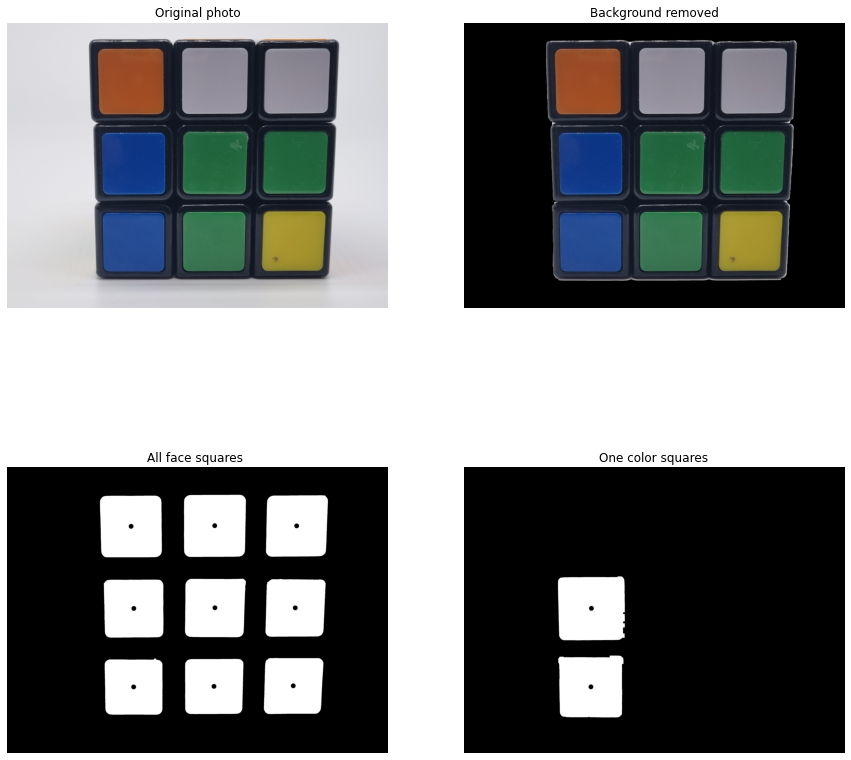

In [ ]:
img_offset = 0 # used to show some images useful for explanation

for face in faces:
  white = "W"
  face_map = [white]*9
  original_img = cv2.imread("/content/drive/My Drive/rubik/"+face+".jpg")
  
  #1. Isolate the cube's face by background removal
  img = removeBG(original_img)

  #2. Extract the nine face's squares in a binary image
  all_squares = 255 - extractColor("black", img, iter = 4)
  
  #3. Draw contours of the nine squares
  #4. Compute centroids of each contour
  all_centroids = centroids(all_squares)

  #5. Sort centroids from top-to-bottom and...
  temp_sorted_centroids = sorted(all_centroids, key=lambda x: x[1])
  
  # ...sort centroids by rows of 3 squares (left-to-right)
  i = 0
  row = []
  all_sorted_centroids = []
  for x,y in temp_sorted_centroids:
    i += 1
    row.append((x,y))
    if i % 3 == 0:
      sorted_row = sorted(row, key=lambda x: x[0])
      for j in range(0,3): all_sorted_centroids.append(sorted_row[j]) 
      i = 0 
      row = []

  for col in col_names[:5]:
    indexes = []
    
    #6. Mask the the squares for a single color in a binary image, draw contours, and compute centroids
    mask_color = extractColor(col, img, iter = 3)
    cent = centroids(mask_color)

    #### code to show result for first face
    if img_offset == 0:
      fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(15,15))
      axs[0,0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
      axs[0,0].set_title("Original photo")
      axs[0,0].axis('off')
      axs[0,1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axs[0,1].set_title("Background removed")
      axs[0,1].axis('off')
      axs[1,0].imshow(cv2.cvtColor(all_squares, cv2.COLOR_BGR2RGB))
      axs[1,0].set_title("All face squares ")
      axs[1,0].axis('off')
      axs[1,1].imshow(cv2.cvtColor(mask_color, cv2.COLOR_BGR2RGB))
      axs[1,1].set_title("One color squares")
      axs[1,1].axis('off')
      plt.show()
    
      img_offset += 1
    ####
    
    #7. Compare just found centroids with the reference ones and retrieve the color position among the nine squares
    indexes = compare(all_sorted_centroids, cent)
    if indexes:
      for ind in indexes:
        face_map[ind] = col

  map[face] = "".join(face_map)     

In [ ]:
print("Extracted color sequence, row by row, for each cube's face\n\n", map)

input_for_solver = map["top"]+ \
                   map["left"][:3] + map["front"][:3] + map["right"][:3] + map["back"][:3] + \
                   map["left"][3:6] + map["front"][3:6] + map["right"][3:6] + map["back"][3:6] + \
                   map["left"][6:9] + map["front"][6:9] + map["right"][6:9] + map["back"][6:9] + \
                   map["bottom"]

print("\n\nInput for second part of the project\n\n", input_for_solver)

Extracted color sequence, row by row, for each cube's face

 {'top': 'OWWBGGBGY', 'left': 'WOYGRGYYY', 'front': 'ORGWWWGRG', 'right': 'OOBBOBWWW', 'back': 'OOGYYYBOB', 'bottom': 'RBRRBRRYR'}


Input for second part of the project

 OWWBGGBGYWOYORGOOBOOGGRGWWWBOBYYYYYYGRGWWWBOBRBRRBRRYR


**Limits**

This methods doesn't work well for the white color. That's why we initialize the face color map with all white squares. We don't mask white color in the "single color masking loop" and just replace positions that corresponds to the other colors.


---



### **Method B**
**Workflow**

1. Isolate the cube's face by background removal
2. Extract the nine face's squares in a binary image
3. Draw contours of the nine squares
4. Sort the contours from top-to-bottom and from left-to-right
5. for each square:

  6. for each color:

      7. Try to mask that color in that square
      8. The only color that doesn't return and empty masking is the square color


Initialize the array containing the names of the cube's faces photos (order is not important) and the array that will contain the color map in string format.

In [ ]:
faces = ["top", "left", "front", "right", "back", "bottom"]
map = {}

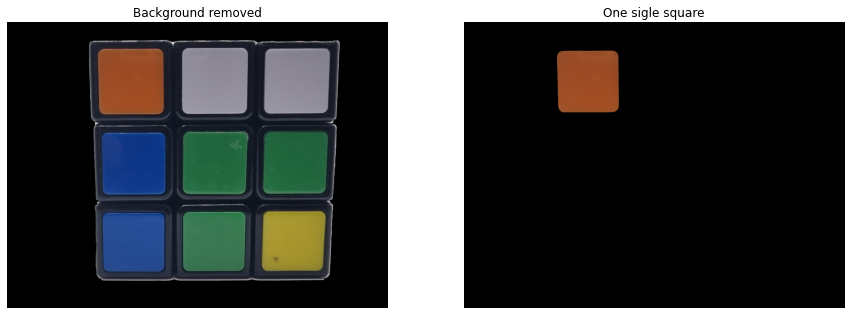

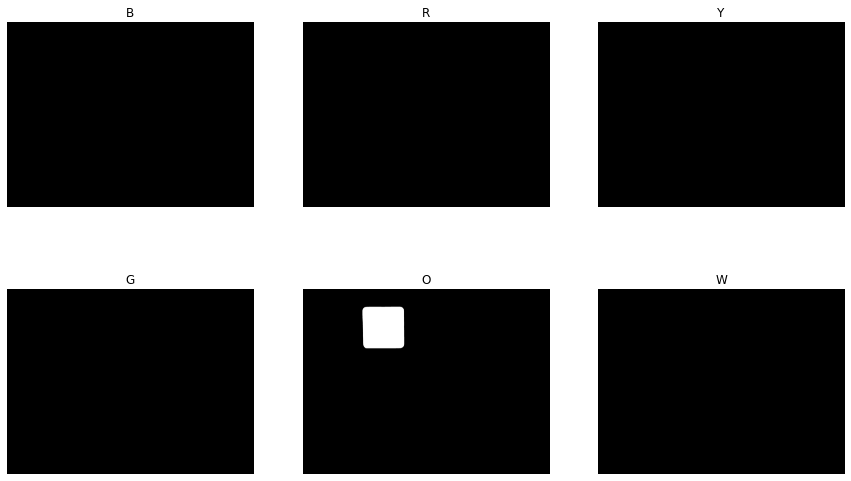

In [ ]:
img_offset = 0 # used to show some images useful for explanation

for face in faces:
  face_map = ""
  original_img = cv2.imread("/content/drive/My Drive/rubik/"+face+".jpg")
  #1. Isolate the cube's face by background removal
  img = removeBG(original_img)
  
  #2. Extract the nine face's squares in a binary image
  all_squares = 255 - extractColor("black", img, iter = 4)

  #3. Draw contours of the nine squares
  cnts, _ = cv2.findContours(all_squares, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #4. Sort contours from left-to-right and... 
  tmp_sort_contours = contours.sort_contours(cnts, method="top-to-bottom")[0]

  # ...take each row of 3 and sort from left-to-right 
  cube_rows = []
  row = []
  for (i, c) in enumerate(tmp_sort_contours, 1):
      row.append(c)
      if i % 3 == 0:  
          (cnts, _) = contours.sort_contours(row, method="left-to-right")
          cube_rows.append(cnts)
          row = []
 
  for row in cube_rows:
    for c in row:
      mask_cube = np.zeros(img.shape[:2], np.uint8)
      cv2.drawContours(mask_cube, [c], -1, 255, -1)
      cube_img = cv2.bitwise_and(img, img, mask = mask_cube)
      
      #### code to show result for first face
      if img_offset == 0:
        fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize=(15,15))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Background removed")
        axs[0].axis('off')
        axs[1].imshow(cv2.cvtColor(cube_img, cv2.COLOR_BGR2RGB))
        axs[1].set_title("One sigle square")
        axs[1].axis('off')
        plt.show()

        print("\n\n")  
        fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(15,9))
        plt_row, plt_col = 0,0
      ####

      for col in col_names:
        #7. Try to mask that color in that square
        mask_color = extractColor(col, cube_img, iter=3)
        
        #### code to show result for first face
        if img_offset == 0:
          axs[plt_row, plt_col].imshow(cv2.cvtColor(mask_color, cv2.COLOR_BGR2RGB))
          axs[plt_row, plt_col].set_title(col)
          axs[plt_row, plt_col].axis('off')
          plt_col += 1
          if plt_col % 3 == 0:
            plt_col = 0
            plt_row += 1
        ###

        #8. The only color that doesn't return and empty masking is the square color
        if np.all((mask_color==0)):
          pass
        else:
          face_map = face_map + col
      
      ###
      if img_offset == 0: 
        plt.show()
      img_offset += 1
      ###
      
  map[face] = face_map     


In [ ]:
print("Extracted color sequence, row by row, for each cube's face\n\n", map)

input_for_solver = map["top"]+ \
                   map["left"][:3] + map["front"][:3] + map["right"][:3] + map["back"][:3] + \
                   map["left"][3:6] + map["front"][3:6] + map["right"][3:6] + map["back"][3:6] + \
                   map["left"][6:9] + map["front"][6:9] + map["right"][6:9] + map["back"][6:9] + \
                   map["bottom"]

print("\n\nInput for second part of the project\n\n", input_for_solver)

Extracted color sequence, row by row, for each cube's face

 {'top': 'OWWBGGBGY', 'left': 'WOYGRGYYY', 'front': 'ORGWWWGRG', 'right': 'OOBBOBWWW', 'back': 'OOGYYYBOB', 'bottom': 'RBRRBRRYR'}


Input for second part of the project

 OWWBGGBGYWOYORGOOBOOGGRGWWWBOBYYYYYYGRGWWWBOBRBRRBRRYR


**Limits**

This method is much slower than the previous one.


---



## **PART 2: Rubik's cube solver**

**Layer by layer method**

<img src="https://i.ibb.co/CBPqyyQ/Whats-App-Image-2022-02-04-at-15-55-00.jpg" alt="Whats-App-Image-2022-02-04-at-15-55-00" border="0" width="800" height="auto">


The implementation relies on the solution presented [here](https://github.com/pglass/cube). This is a Python 3 implementation of a (3x3) Rubik's Cube solver from which the file maths.py was used to define a 3D point/vector and a 3x3 matrix used to store the six faces of the rubik's cube.

The package is hosted on PyPI. Use the following line to install it:

`>>> !pip install rubik-cube`

**class Piece**

The Piece uses the combination of position and color vectors that makes it easy to identify any Piece by its absolute position or by its unique combination of colors. It stores two pieces of information:
1.	An integer position vector (x, y, z) where each component is in {-1, 0, 1}:

> - (0, 0, 0) is the center of the cube
-the positive x-axis points to the right face
- the positive y-axis points to the up face
- the positive z-axis points to the front face


2.	A colors vector (cx, cy, cz), giving the color of the sticker along each axis. Null values are place whenever that Piece has less than three sides. 

The Piece class also contains the "rotate" function that traces all pieces in case of rotation.

**class Cube**

The Cube provides methods for flipping slices of the cube by appling the appropriate rotation matrix to all Pieces involved in the rotation. 

**class Solver**

The Solver implements the layer- by-layer algorithm described [here](http://ozcubegirl.com/rubikscubesolution.html).

First the front-face (the z = 1 plane) is solved, then the middle layer (z = 0), and finally the back layer (z = -1). When the solver is done, "Solver.moves" is a list representing the solution sequence.

**class optimize**

The optimizer does the following:
1.	Eliminate full-cube rotations by "unrotating" the moves (Z U L D Zi becomes L D R)
2.	Eliminate moves followed by their inverse (R R Ri Ri is gone)
3.	Replace moves repeated three times with a single turn in the opposite direction (R R R becomes Ri)
4.  Replace moves repeated two times with the 2x notation (R R becomes 2 R)

In [ ]:
!pip install rubik-cube

In [ ]:
import string
from rubik.maths import Point, Matrix

RIGHT = X_AXIS = Point(1, 0, 0)
LEFT           = Point(-1, 0, 0)
UP    = Y_AXIS = Point(0, 1, 0)
DOWN           = Point(0, -1, 0)
FRONT = Z_AXIS = Point(0, 0, 1)
BACK           = Point(0, 0, -1)

FACE = 'face'
EDGE = 'edge'
CORNER = 'corner'


# 90 degree rotations in the XY plane. CW is clockwise, CC is counter-clockwise.
ROT_XY_CW = Matrix(0, 1, 0,
                   -1, 0, 0,
                   0, 0, 1)
ROT_XY_CC = Matrix(0, -1, 0,
                   1, 0, 0,
                   0, 0, 1)

# 90 degree rotations in the XZ plane (around the y-axis when viewed pointing toward you).
ROT_XZ_CW = Matrix(0, 0, -1,
                   0, 1, 0,
                   1, 0, 0)
ROT_XZ_CC = Matrix(0, 0, 1,
                   0, 1, 0,
                   -1, 0, 0)

# 90 degree rotations in the YZ plane (around the x-axis when viewed pointing toward you).
ROT_YZ_CW = Matrix(1, 0, 0,
                   0, 0, 1,
                   0, -1, 0)
ROT_YZ_CC = Matrix(1, 0, 0,
                   0, 0, -1,
                   0, 1, 0)


def get_rot_from_face(face): #rot=rotation
    """
    :param face: One of FRONT, BACK, LEFT, RIGHT, UP, DOWN
    :return: A pair (CW, CC) given the clockwise and counterclockwise rotations for that face
    """
    if face == RIGHT:   return "R", "Ri"
    elif face == LEFT:  return "L", "Li"
    elif face == UP:    return "U", "Ui"
    elif face == DOWN:  return "D", "Di"
    elif face == FRONT: return "F", "Fi"
    elif face == BACK:  return "B", "Bi"
    return None


class Piece:

    def __init__(self, pos, colors):
        """
        :param pos: A tuple of integers (x, y, z) each ranging from -1 to 1
        :param colors: A tuple of length three (x, y, z) where each component gives the color
            of the side of the piece on that axis (if it exists), or None.
        """
        self.pos = pos
        self.colors = list(colors)
        self._set_piece_type()

    def __str__(self):
        colors = "".join(c for c in self.colors if c is not None)
        return f"({self.type}, {colors}, {self.pos})"

    def _set_piece_type(self):
        if self.colors.count(None) == 2:
            self.type = FACE
        elif self.colors.count(None) == 1:
            self.type = EDGE
        elif self.colors.count(None) == 0:
            self.type = CORNER
        else:
            raise ValueError(f"Must have 1, 2, or 3 colors - given colors={self.colors}")

    def rotate(self, matrix):
        """Apply the given rotation matrix to this piece."""
        before = self.pos
        self.pos = matrix * self.pos

        # we need to swap the positions of two things in self.colors so colors appear
        # on the correct faces. rot gives us the axes to swap between.
        rot = self.pos - before
        if not any(rot):
            return  # no change occurred
        if rot.count(0) == 2:
            rot += matrix * rot

        i, j = (i for i, x in enumerate(rot) if x != 0)
        self.colors[i], self.colors[j] = self.colors[j], self.colors[i]


class Cube:
    """Stores Pieces which are addressed through an x-y-z coordinate system:
        -x is the LEFT direction, +x is the RIGHT direction
        -y is the DOWN direction, +y is the UP direction
        -z is the BACK direction, +z is the FRONT direction
    """
    
    def _from_cube(self, c):
        self.faces = [Piece(pos=Point(p.pos), colors=p.colors) for p in c.faces]
        self.edges = [Piece(pos=Point(p.pos), colors=p.colors) for p in c.edges]
        self.corners = [Piece(pos=Point(p.pos), colors=p.colors) for p in c.corners]
        self.pieces = self.faces + self.edges + self.corners

    def __init__(self, cube_str):
        
        if isinstance(cube_str, Cube):
            self._from_cube(cube_str)
            return

        cube_str = "".join(x for x in cube_str if x not in string.whitespace)
        self.faces = (
            Piece(pos=RIGHT, colors=(cube_str[28], None, None)),
            Piece(pos=LEFT,  colors=(cube_str[22], None, None)),
            Piece(pos=UP,    colors=(None, cube_str[4],  None)),
            Piece(pos=DOWN,  colors=(None, cube_str[49], None)),
            Piece(pos=FRONT, colors=(None, None, cube_str[25])),
            Piece(pos=BACK,  colors=(None, None, cube_str[31])))
        self.edges = (
            Piece(pos=RIGHT + UP,    colors=(cube_str[16], cube_str[5], None)),
            Piece(pos=RIGHT + DOWN,  colors=(cube_str[40], cube_str[50], None)),
            Piece(pos=RIGHT + FRONT, colors=(cube_str[27], None, cube_str[26])),
            Piece(pos=RIGHT + BACK,  colors=(cube_str[29], None, cube_str[30])),
            Piece(pos=LEFT + UP,     colors=(cube_str[10], cube_str[3], None)),
            Piece(pos=LEFT + DOWN,   colors=(cube_str[34], cube_str[48], None)),
            Piece(pos=LEFT + FRONT,  colors=(cube_str[23], None, cube_str[24])),
            Piece(pos=LEFT + BACK,   colors=(cube_str[21], None, cube_str[32])),
            Piece(pos=UP + FRONT,    colors=(None, cube_str[7], cube_str[13])),
            Piece(pos=UP + BACK,     colors=(None, cube_str[1], cube_str[19])),
            Piece(pos=DOWN + FRONT,  colors=(None, cube_str[46], cube_str[37])),
            Piece(pos=DOWN + BACK,   colors=(None, cube_str[52], cube_str[43])),
        )
        self.corners = (
            Piece(pos=RIGHT + UP + FRONT,   colors=(cube_str[15], cube_str[8], cube_str[14])),
            Piece(pos=RIGHT + UP + BACK,    colors=(cube_str[17], cube_str[2], cube_str[18])),
            Piece(pos=RIGHT + DOWN + FRONT, colors=(cube_str[39], cube_str[47], cube_str[38])),
            Piece(pos=RIGHT + DOWN + BACK,  colors=(cube_str[41], cube_str[53], cube_str[42])),
            Piece(pos=LEFT + UP + FRONT,    colors=(cube_str[11], cube_str[6], cube_str[12])),
            Piece(pos=LEFT + UP + BACK,     colors=(cube_str[9], cube_str[0], cube_str[20])),
            Piece(pos=LEFT + DOWN + FRONT,  colors=(cube_str[35], cube_str[45], cube_str[36])),
            Piece(pos=LEFT + DOWN + BACK,   colors=(cube_str[33], cube_str[51], cube_str[44])),
        )

        self.pieces = self.faces + self.edges + self.corners
    
    
    
    def is_solved(self):
        def check(colors):
            return all(c == colors[0] for c in colors)
        return (check([piece.colors[2] for piece in self._face(FRONT)]) and
                check([piece.colors[2] for piece in self._face(BACK)]) and
                check([piece.colors[1] for piece in self._face(UP)]) and
                check([piece.colors[1] for piece in self._face(DOWN)]) and
                check([piece.colors[0] for piece in self._face(LEFT)]) and
                check([piece.colors[0] for piece in self._face(RIGHT)]))
    
    def _face(self, axis):
        """
        :param axis: One of LEFT, RIGHT, UP, DOWN, FRONT, BACK
        :return: A list of Pieces on the given face
        """
        return [p for p in self.pieces if p.pos.dot(axis) > 0]

    def _slice(self, plane):
        """
        :param plane: A sum of any two of X_AXIS, Y_AXIS, Z_AXIS (e.g. X_AXIS + Y_AXIS)
        :return: A list of Pieces in the given plane
        """

        i = next((i for i, x in enumerate(plane) if x == 0))
        return [p for p in self.pieces if p.pos[i] == 0]

    def _rotate_face(self, face, matrix):
        self._rotate_pieces(self._face(face), matrix)

    def _rotate_slice(self, plane, matrix):
        self._rotate_pieces(self._slice(plane), matrix)

    def _rotate_pieces(self, pieces, matrix):
        for piece in pieces:
            piece.rotate(matrix)

    # Rubik's Cube Notation: http://ruwix.com/the-rubiks-cube/notation/
    def L(self):  self._rotate_face(LEFT, ROT_YZ_CC)
    def Li(self): self._rotate_face(LEFT, ROT_YZ_CW)
    def R(self):  self._rotate_face(RIGHT, ROT_YZ_CW)
    def Ri(self): self._rotate_face(RIGHT, ROT_YZ_CC)
    def U(self):  self._rotate_face(UP, ROT_XZ_CW)
    def Ui(self): self._rotate_face(UP, ROT_XZ_CC)
    def D(self):  self._rotate_face(DOWN, ROT_XZ_CC)
    def Di(self): self._rotate_face(DOWN, ROT_XZ_CW)
    def F(self):  self._rotate_face(FRONT, ROT_XY_CW)
    def Fi(self): self._rotate_face(FRONT, ROT_XY_CC)
    def B(self):  self._rotate_face(BACK, ROT_XY_CC)
    def Bi(self): self._rotate_face(BACK, ROT_XY_CW)
    def M(self):  self._rotate_slice(Y_AXIS + Z_AXIS, ROT_YZ_CC)
    def Mi(self): self._rotate_slice(Y_AXIS + Z_AXIS, ROT_YZ_CW)
    def E(self):  self._rotate_slice(X_AXIS + Z_AXIS, ROT_XZ_CC)
    def Ei(self): self._rotate_slice(X_AXIS + Z_AXIS, ROT_XZ_CW)
    def S(self):  self._rotate_slice(X_AXIS + Y_AXIS, ROT_XY_CW)
    def Si(self): self._rotate_slice(X_AXIS + Y_AXIS, ROT_XY_CC)
    def X(self):  self._rotate_pieces(self.pieces, ROT_YZ_CW)
    def Xi(self): self._rotate_pieces(self.pieces, ROT_YZ_CC)
    def Y(self):  self._rotate_pieces(self.pieces, ROT_XZ_CW)
    def Yi(self): self._rotate_pieces(self.pieces, ROT_XZ_CC)
    def Z(self):  self._rotate_pieces(self.pieces, ROT_XY_CW)
    def Zi(self): self._rotate_pieces(self.pieces, ROT_XY_CC)

    
    def sequence(self, move_str):
        """
        :param moves: A string containing notated moves separated by spaces: "L Ri U M Ui B M"
        """
        moves = [getattr(self, name) for name in move_str.split()]
        for move in moves:
            move()
    
    def find_piece(self, *colors):
        if None in colors:
            return
        for p in self.pieces:
            if p.colors.count(None) == 3 - len(colors) \
                and all(c in p.colors for c in colors):
                return p

    def get_piece(self, x, y, z):
        """
        :return: the Piece at the given Point
        """
        point = Point(x, y, z)
        for p in self.pieces:
            if p.pos == point:
                return p
    
    def __getitem__(self, *args):
        if len(args) == 1:
            return self.get_piece(*args[0])
        return self.get_piece(*args)

    def colors(self):
        """
        :return: A set containing the colors of all stickers on the cube
        """
        return set(c for piece in self.pieces for c in piece.colors if c is not None)

    def left_color(self): return self[LEFT].colors[0]
    def right_color(self): return self[RIGHT].colors[0]
    def up_color(self): return self[UP].colors[1]
    def down_color(self): return self[DOWN].colors[1]
    def front_color(self): return self[FRONT].colors[2]
    def back_color(self): return self[BACK].colors[2]
    
    def _color_list(self):
        right = [p.colors[0] for p in sorted(self._face(RIGHT), key=lambda p: (-p.pos.y, -p.pos.z))]
        left  = [p.colors[0] for p in sorted(self._face(LEFT),  key=lambda p: (-p.pos.y, p.pos.z))]
        up    = [p.colors[1] for p in sorted(self._face(UP),    key=lambda p: (p.pos.z, p.pos.x))]
        down  = [p.colors[1] for p in sorted(self._face(DOWN),  key=lambda p: (-p.pos.z, p.pos.x))]
        front = [p.colors[2] for p in sorted(self._face(FRONT), key=lambda p: (-p.pos.y, p.pos.x))]
        back  = [p.colors[2] for p in sorted(self._face(BACK),  key=lambda p: (-p.pos.y, -p.pos.x))]

        return (up + left[0:3] + front[0:3] + right[0:3] + back[0:3]
                   + left[3:6] + front[3:6] + right[3:6] + back[3:6]
                   + left[6:9] + front[6:9] + right[6:9] + back[6:9] + down)
    
    
    def __str__(self):
        template = ("    {}{}{}\n"
                    "    {}{}{}\n"
                    "    {}{}{}\n"
                    "{}{}{} {}{}{} {}{}{} {}{}{}\n"
                    "{}{}{} {}{}{} {}{}{} {}{}{}\n"
                    "{}{}{} {}{}{} {}{}{} {}{}{}\n"
                    "    {}{}{}\n"
                    "    {}{}{}\n"
                    "    {}{}{}")

        return "    " + template.format(*self._color_list()).strip()


class Solver:

    def __init__(self, c):
        self.cube = c
        self.colors = c.colors()
        self.moves = []

        self.left_piece  = self.cube.find_piece(self.cube.left_color())
        self.right_piece = self.cube.find_piece(self.cube.right_color())
        self.up_piece    = self.cube.find_piece(self.cube.up_color())
        self.down_piece  = self.cube.find_piece(self.cube.down_color())

    def move(self, move_str):
        self.moves.extend(move_str.split())
        self.cube.sequence(move_str)

    def cross(self):
 
        # find the 4 arms of the cross and return type, colour and position (edge, YW, (-1, 0, 1))
        fl_piece = self.cube.find_piece(self.cube.front_color(), self.cube.left_color())
        fr_piece = self.cube.find_piece(self.cube.front_color(), self.cube.right_color())
        fu_piece = self.cube.find_piece(self.cube.front_color(), self.cube.up_color())
        fd_piece = self.cube.find_piece(self.cube.front_color(), self.cube.down_color())

        # There are 4 edge pieces with white (ie. the 4 arms of the cross) which 
        # have specific positions. The other colour of the edge should be putted 
        # in such a position to match up with it's centre on the middle layer.
        # http://www.cubestation.co.uk/cs2/index.php?page=3x3x3/cfop/cross/cross

        self._cross_left_or_right(fl_piece, self.left_piece, self.cube.left_color(), "L L", "E L Ei Li")
        self._cross_left_or_right(fr_piece, self.right_piece, self.cube.right_color(), "R R", "Ei R E Ri")

        self.move("Z")
        self._cross_left_or_right(fd_piece, self.down_piece, self.cube.left_color(), "L L", "E L Ei Li")
        self._cross_left_or_right(fu_piece, self.up_piece, self.cube.right_color(), "R R", "Ei R E Ri")
        self.move("Zi")

    def _cross_left_or_right(self, edge_piece, face_piece, face_color, move_1, move_2):
        
        # Extreme case: the cube pieces are in the wrong position
        if edge_piece is None: 
          raise Exception("The cube is biased, please restart the program")

        else:
            # don't do anything if piece is in correct place (edge has the seme color of the centroid)
            if (edge_piece.pos == (face_piece.pos.x, face_piece.pos.y, 1)
                and edge_piece.colors[2] == self.cube.front_color()):
                return

            # ensure piece is at z = -1
            undo_move = None
            if edge_piece.pos.z == 0:
                pos = Point(edge_piece.pos)
                pos.x = 0  # pick the UP or DOWN face
                cw, cc = get_rot_from_face(pos)

                if edge_piece.pos in (LEFT + UP, RIGHT + DOWN):
                    self.move(cw)
                    undo_move = cc
                else:
                    self.move(cc)
                    undo_move = cw
            
            elif edge_piece.pos.z == 1:
                pos = Point(edge_piece.pos)
                pos.z = 0
                cw, cc = get_rot_from_face(pos)
                self.move("{0} {0}".format(cc))
                
                # don't set the undo move if the piece starts out in the right position
                if edge_piece.pos.x != face_piece.pos.x:
                    undo_move = "{0} {0}".format(cw)

            # piece is at z = -1, rotate to correct face (LEFT or RIGHT)
            count = 0
            while (edge_piece.pos.x, edge_piece.pos.y) != (face_piece.pos.x, face_piece.pos.y):
                self.move("B")
                count += 1
                if count == 10:
                    raise Exception("Stuck in loop - unsolvable cube?\n" + str(self.cube))

            # if we moved a correctly-placed piece, restore it
            if undo_move:
                self.move(undo_move)

           # the piece is on the correct face on plane z = -1, but has two orientations
            if edge_piece.colors[0] == face_color:
               self.move(move_1)
            else:
                self.move(move_2)

    def first_layer_corners(self):

        # Find white corner pieces at the to player,and put that corner on top of the matched position.
        fld_piece = self.cube.find_piece(self.cube.front_color(), self.cube.left_color(), self.cube.down_color())
        flu_piece = self.cube.find_piece(self.cube.front_color(), self.cube.left_color(), self.cube.up_color())
        frd_piece = self.cube.find_piece(self.cube.front_color(), self.cube.right_color(), self.cube.down_color())
        fru_piece = self.cube.find_piece(self.cube.front_color(), self.cube.right_color(), self.cube.up_color())

        # Execute the right moves according to the situations: https://ruwix.com/the-rubiks-cube/how-to-solve-the-rubiks-cube-beginners-method/step-2-first-layer-corners/
        self.place_frd_corner(frd_piece, self.right_piece, self.down_piece, self.cube.front_color())
        self.move("Z")
        self.place_frd_corner(fru_piece, self.up_piece, self.right_piece, self.cube.front_color())
        self.move("Z")
        self.place_frd_corner(flu_piece, self.left_piece, self.up_piece, self.cube.front_color())
        self.move("Z")
        self.place_frd_corner(fld_piece, self.down_piece, self.left_piece, self.cube.front_color())
        self.move("Z")

    def place_frd_corner(self, corner_piece, right_piece, down_piece, front_color):
        # rotate to z = -1
        if corner_piece.pos.z == 1:
            pos = Point(corner_piece.pos)
            pos.x = pos.z = 0
            cw, cc = get_rot_from_face(pos)

            # be careful not to screw up other pieces on the front face
            count = 0
            undo_move = cc
            while corner_piece.pos.z != -1:
                self.move(cw)
                count += 1

            if count > 1:
                for _ in range(count):
                    self.move(cc)

                count = 0
                while corner_piece.pos.z != -1:
                    self.move(cc)
                    count += 1
                undo_move = cw
            self.move("B")
            for _ in range(count):
                self.move(undo_move)

        # rotate piece to be directly below its destination
        while (corner_piece.pos.x, corner_piece.pos.y) != (right_piece.pos.x, down_piece.pos.y):
            self.move("B")

        # three possible orientations for a corner
        if corner_piece.colors[0] == front_color:
            self.move("B D Bi Di")
        elif corner_piece.colors[1] == front_color:
            self.move("Bi Ri B R")
        else:
            self.move("Ri B B R Bi Bi D Bi Di")

    def middle_layer(self):
        
        # Find the edge which is not with yellow, and match its side color
        rd_piece = self.cube.find_piece(self.cube.right_color(), self.cube.down_color())
        ru_piece = self.cube.find_piece(self.cube.right_color(), self.cube.up_color())
        ld_piece = self.cube.find_piece(self.cube.left_color(), self.cube.down_color())
        lu_piece = self.cube.find_piece(self.cube.left_color(), self.cube.up_color())

        self.place_middle_layer_ld_edge(ld_piece, self.cube.left_color(), self.cube.down_color())
        self.move("Z")
        self.place_middle_layer_ld_edge(rd_piece, self.cube.left_color(), self.cube.down_color())
        self.move("Z")
        self.place_middle_layer_ld_edge(ru_piece, self.cube.left_color(), self.cube.down_color())
        self.move("Z")
        self.place_middle_layer_ld_edge(lu_piece, self.cube.left_color(), self.cube.down_color())
        self.move("Z")

    def place_middle_layer_ld_edge(self, ld_piece, left_color, down_color):
        
        # move to z == -1
        if ld_piece.pos.z == 0:
            count = 0
            while (ld_piece.pos.x, ld_piece.pos.y) != (-1, -1):
                self.move("Z")
                count += 1

            self.move("B L Bi Li Bi Di B D")
            for _ in range(count):
                self.move("Zi")

        if ld_piece.colors[2] == left_color:
            # left_color is on the back face, move piece to to down face
            while ld_piece.pos.y != -1:
                self.move("B")
            self.move("B L Bi Li Bi Di B D")
        elif ld_piece.colors[2] == down_color:
            # down_color is on the back face, move to left face
            while ld_piece.pos.x != -1:
                self.move("B")
            self.move("Bi Di B D B L Bi Li")

    def back_face_edges(self):

        # rotate BACK to FRONT
        self.move("X X")

        # States:  1     2     3     4
        #         -B-   -B-   ---   ---
        #         BBB   BB-   BBB   -B-
        #         -B-   ---   ---   ---
        def state1():
            return (self.cube[0, 1, 1].colors[2] == self.cube.front_color() and
                    self.cube[-1, 0, 1].colors[2] == self.cube.front_color() and
                    self.cube[0, -1, 1].colors[2] == self.cube.front_color() and
                    self.cube[1, 0, 1].colors[2] == self.cube.front_color())

        def state2():
            return (self.cube[0, 1, 1].colors[2] == self.cube.front_color() and
                    self.cube[-1, 0, 1].colors[2] == self.cube.front_color())

        def state3():
            return (self.cube[-1, 0, 1].colors[2] == self.cube.front_color() and
                    self.cube[1, 0, 1].colors[2] == self.cube.front_color())

        def state4():
            return (self.cube[0, 1, 1].colors[2] != self.cube.front_color() and
                    self.cube[-1, 0, 1].colors[2] != self.cube.front_color() and
                    self.cube[0, -1, 1].colors[2] != self.cube.front_color() and
                    self.cube[1, 0, 1].colors[2] != self.cube.front_color())

        while not state1():
            if state4() or state2():
                self.move("D F R Fi Ri Di")
            elif state3():
                self.move("D R F Ri Fi Di")
            else:
                self.move("F")
        self.move("Xi Xi")

    def last_layer_corners_position(self):

        self.move("X X")

        move_1 = "Li Fi L D F Di Li F L F F "  # swaps 1 and 2
        move_2 = "F Li Fi L D F Di Li F L F "  # swaps 1 and 3

        c2 = self.cube.find_piece(self.cube.front_color(), self.cube.left_color(), self.cube.down_color())
        c3 = self.cube.find_piece(self.cube.front_color(), self.cube.right_color(), self.cube.up_color())
        c4 = self.cube.find_piece(self.cube.front_color(), self.cube.left_color(), self.cube.up_color())

        # place corner 4
        if c4.pos == Point(1, -1, 1):
            self.move(move_1 + "Zi " + move_1 + " Z")
        elif c4.pos == Point(1, 1, 1):
            self.move("Z " + move_2 + " Zi")
        elif c4.pos == Point(-1, -1, 1):
            self.move("Zi " + move_1 + " Z")

        # place corner 2
        if c2.pos == Point(1, 1, 1):
            self.move(move_2 + move_1)
        elif c2.pos == Point(1, -1, 1):
            self.move(move_1)

        # place corner 3 and corner 1
        if c3.pos == Point(1, -1, 1):
            self.move(move_2)

        self.move("Xi Xi")

    def last_layer_corners_orientation(self):
 
        self.move("X X")

        # States:  1        2      3      4      5      6      7      8
        #           B      B             B      B        B
        #         BB-      -B-B   BBB    -BB    -BB   B-B-   B-B-B   BBB
        #         BBB      BBB    BBB    BBB    BBB    BBB    BBB    BBB
        #         -B-B     BB-    -B-    -BB    BB-B  B-B-   B-B-B   BBB
        #         B          B    B B    B               B
        def state1():
            return (self.cube[ 1,  1, 1].colors[1] == self.cube.front_color() and
                    self.cube[-1, -1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[0] == self.cube.front_color())

        def state2():
            return (self.cube[-1,  1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 1,  1, 1].colors[0] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[1] == self.cube.front_color())

        def state3():
            return (self.cube[-1, -1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[1] == self.cube.front_color() and
                    self.cube[-1,  1, 1].colors[2] == self.cube.front_color() and
                    self.cube[ 1,  1, 1].colors[2] == self.cube.front_color())

        def state4():
            return (self.cube[-1,  1, 1].colors[1] == self.cube.front_color() and
                    self.cube[-1, -1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 1,  1, 1].colors[2] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[2] == self.cube.front_color())

        def state5():
            return (self.cube[-1,  1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[0] == self.cube.front_color())

        def state6():
            return (self.cube[ 1,  1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[1] == self.cube.front_color() and
                    self.cube[-1, -1, 1].colors[0] == self.cube.front_color() and
                    self.cube[-1,  1, 1].colors[0] == self.cube.front_color())

        def state7():
            return (self.cube[ 1,  1, 1].colors[0] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[0] == self.cube.front_color() and
                    self.cube[-1, -1, 1].colors[0] == self.cube.front_color() and
                    self.cube[-1,  1, 1].colors[0] == self.cube.front_color())

        def state8():
            return (self.cube[ 1,  1, 1].colors[2] == self.cube.front_color() and
                    self.cube[ 1, -1, 1].colors[2] == self.cube.front_color() and
                    self.cube[-1, -1, 1].colors[2] == self.cube.front_color() and
                    self.cube[-1,  1, 1].colors[2] == self.cube.front_color())

        move_1 = "Ri Fi R Fi Ri F F R F F "
        move_2 = "R F Ri F R F F Ri F F "

        while not state8():
            if state1(): self.move(move_1)
            elif state2(): self.move(move_2)
            elif state3(): self.move(move_2 + "F F " + move_1)
            elif state4(): self.move(move_2 + move_1)
            elif state5(): self.move(move_1 + "F " + move_2)
            elif state6(): self.move(move_1 + "Fi " + move_1)
            elif state7(): self.move(move_1 + "F F " + move_1)
            else:
                self.move("F")

        # rotate corners into correct locations (cube is inverted, so swap up and down colors)
        bru_corner = self.cube.find_piece(self.cube.front_color(), self.cube.right_color(), self.cube.up_color())
        while bru_corner.pos != Point(1, 1, 1):
            self.move("F")

        self.move("Xi Xi")

    def last_layer_edges(self):

        self.move("X X")

        br_edge = self.cube.find_piece(self.cube.front_color(), self.cube.right_color())
        bl_edge = self.cube.find_piece(self.cube.front_color(), self.cube.left_color())
        bu_edge = self.cube.find_piece(self.cube.front_color(), self.cube.up_color())
        bd_edge = self.cube.find_piece(self.cube.front_color(), self.cube.down_color())

        # States:
        #       1              2
        #      ---            ---
        #      ---            ---
        #      -B-            -a-
        #  --- B-B ---    aaa BBB ---
        #  --B -B- B--    aaB -B- B--
        #  --- B-B ---    aaa B-B ---
        #      -B-            -B-
        #      ---            ---
        #      ---            ---
        #              (aB edge on any FRONT)
        def state1():
            return (bu_edge.colors[2] != self.cube.front_color() and
                    bd_edge.colors[2] != self.cube.front_color() and
                    bl_edge.colors[2] != self.cube.front_color() and
                    br_edge.colors[2] != self.cube.front_color())

        def state2():
            return (bu_edge.colors[2] == self.cube.front_color() or
                    bd_edge.colors[2] == self.cube.front_color() or
                    bl_edge.colors[2] == self.cube.front_color() or
                    br_edge.colors[2] == self.cube.front_color())


        cycle_move = "R R F D Ui R R Di U F R R"
        h_pattern_move = "Ri S Ri Ri S S Ri Fi Fi R Si Si Ri Ri Si R Fi Fi "
        fish_move = "Di Li " + h_pattern_move + " L D"

        if state1():
            # ideally, convert state1 into state2
            self._handle_last_layer_state1(cycle_move)
        if state2():
            self._handle_last_layer_state2(cycle_move)

        def h_pattern1():
            return (self.cube[-1,  0, 1].colors[0] != self.cube.left_color() and
                    self.cube[ 1,  0, 1].colors[0] != self.cube.right_color() and
                    self.cube[ 0, -1, 1].colors[1] == self.cube.down_color() and
                    self.cube[ 0,  1, 1].colors[1] == self.cube.up_color())

        def h_pattern2():
            return (self.cube[-1,  0, 1].colors[0] == self.cube.left_color() and
                    self.cube[ 1,  0, 1].colors[0] == self.cube.right_color() and
                    self.cube[ 0, -1, 1].colors[1] == self.cube.front_color() and
                    self.cube[ 0,  1, 1].colors[1] == self.cube.front_color())

        def fish_pattern():
            return (self.cube[FRONT + DOWN].colors[2] == self.cube.down_color() and
                    self.cube[FRONT + RIGHT].colors[2] == self.cube.right_color() and
                    self.cube[FRONT + DOWN].colors[1] == self.cube.front_color() and
                    self.cube[FRONT + RIGHT].colors[0] == self.cube.front_color())

        while not self.cube.is_solved():
            for _ in range(4):
                if fish_pattern():
                    self.move(fish_move)
                    if self.cube.is_solved():
                        return
                else:
                    self.move("Z")

            if h_pattern1():
                self.move(h_pattern_move)
            elif h_pattern2():
                self.move("Z " + h_pattern_move + "Zi")
            else:
                self.move(cycle_move)

        self.move("Xi Xi")

    def _handle_last_layer_state1(self, h_move):
        
        def check_edge_lr():
            return self.cube[LEFT + FRONT].colors[2] == self.cube.left_color()

        count = 0
        while not check_edge_lr():
            self.move("F")

        self.move(h_move)

        for _ in range(count):
            self.move("Fi")


    def _handle_last_layer_state2(self, cycle_move):

        def correct_edge():
            piece = self.cube[LEFT + FRONT]
            if piece.colors[2] == self.cube.front_color() and piece.colors[0] == self.cube.left_color():
                return piece
            piece = self.cube[RIGHT + FRONT]
            if piece.colors[2] == self.cube.front_color() and piece.colors[0] == self.cube.right_color():
                return piece
            piece = self.cube[UP + FRONT]
            if piece.colors[2] == self.cube.front_color() and piece.colors[1] == self.cube.up_color():
                return piece
            piece = self.cube[DOWN + FRONT]
            if piece.colors[2] == self.cube.front_color() and piece.colors[1] == self.cube.down_color():
                return piece

        count = 0
        while True:
            edge = correct_edge()
            if edge is not None:
                break
            else:
                self.move(cycle_move)

            count += 1

            if count % 3 == 0:
                self.move("Z")

            if count == 12:
                raise Exception("Stuck in loop - unsolvable cube:\n" + str(self.cube))

        while edge.pos != Point(-1, 0, 1):
            self.move("Z")

    def solve(self):
        '''
        self.cross()
        self.first_layer_corners()
        self.middle_layer()
        self.back_face_edges()
        self.last_layer_corners_position()
        self.last_layer_corners_orientation()
        self.last_layer_edges()
        '''
        #### code to show resulting moves for each step
        i = 0

        self.cross()
      
        self.first_layer_corners()
        print("first_layer")
        print(self.moves[i:])
        i += len(self.moves[i:])

        self.middle_layer()
        print("middle_layer")
        print(self.moves[i:])
        i += len(self.moves[i:])

        self.back_face_edges()
        self.last_layer_corners_position()
        self.last_layer_corners_orientation()     
        self.last_layer_edges()
        print("last_layer")
        print(self.moves[i:])
        ####

class optimize:

  def _invert(move):
    if move.endswith('i'):
        return move[:1]
    return move + 'i'

  def apply_repeat_three_optimization(moves):
    """ 
    Replace moves repeated three times with a single turn in the opposite 
    direction (R R R becomes Ri) 
    """

    changed = False
    i = 0
    while i < len(moves) - 2:
        if moves[i] == moves[i + 1] == moves[i + 2]:
            moves[i:i + 3] = [optimize._invert(moves[i])]
            changed = True
        else:
            i += 1
    if changed:
        optimize.apply_repeat_three_optimization(moves)

  def apply_do_undo_optimization(moves):
    """ 
    Eliminate moves followed by their inverse (R R Ri Ri is gone) 
    """

    changed = False
    i = 0
    while i < len(moves) - 1:
        if optimize._invert(moves[i]) == moves[i + 1]:
            moves[i:i + 2] = []
            changed = True
        else:
            i += 1
    if changed:
        optimize.apply_do_undo_optimization(moves)

  def get_rot_table(rot):
    """
    come in caso di rotazione sulle assi indicate sis spostano/rinominano le 
    facce clockwise and anticlockwise
    """

    X_ROT_CW = dict(U='F', B='U', D='B', F='D', E='Si', S='E', Y='Z', Z='Yi')
    Y_ROT_CW = dict(B='L', R='B', F='R', L='F', S='Mi', M='S', Z='X', X='Zi')
    Z_ROT_CW = dict(U='L', R='U', D='R', L='D', E='Mi', M='E', Y='Xi', X='Y')

    X_ROT_CC: dict = {v: k for k, v in X_ROT_CW.items()}
    Y_ROT_CC: dict = {v: k for k, v in Y_ROT_CW.items()}
    Z_ROT_CC: dict = {v: k for k, v in Z_ROT_CW.items()}

    if rot == 'X':
        return X_ROT_CW
    elif rot == 'Xi':
        return X_ROT_CC
    elif rot == 'Y':
        return Y_ROT_CW
    elif rot == 'Yi':
        return Y_ROT_CC
    elif rot == 'Z':
        return Z_ROT_CW
    elif rot == 'Zi':
        return Z_ROT_CC

  def _unrotate(rot, moves):
    rot_table = optimize.get_rot_table(rot)
    result = []
    for move in moves:
        if move in rot_table:
            result.append(rot_table[move])
        elif optimize._invert(move) in rot_table:
            result.append(optimize._invert(rot_table[optimize._invert(move)]))
        else:
            result.append(move)
    return result

  def apply_no_full_cube_rotation_optimization(moves):
    """
    Eliminate full-cube rotations by "un-rotating" the moves (Z U L D Zi becomes L D R)
    Senza cambiare quale sia la front face, scambia le azioni con quelle che faresti restando di fronte (se possibile)
    """
    
    rots = {'X', 'Y', 'Z', 'Xi', 'Yi', 'Zi'}
    changed = False
    i = 0
    while i < len(moves):
        if moves[i] not in rots:
            i += 1
            continue

        for j in reversed(range(i + 1, len(moves))): #range(start, stop, step) step diventa -1
            "applichi il campbio solo se trovi un inizio e una fine in cui torni sempre alla stessa faccia"
            if moves[j] == optimize._invert(moves[i]):
                moves[i:j + 1] = optimize._unrotate(moves[i], moves[i + 1:j])
                changed = True
                break
        i += 1
    if changed:
        optimize.apply_no_full_cube_rotation_optimization(moves)

  def double_move(moves):
    
    i = 0
    while i < len(moves) - 1:
        if moves[i] == moves[i + 1] :
            moves[i :i + 2] = str('2'+moves[i])
        i += 1

  def optimize_moves(moves):
    result = list(moves)
    optimize.apply_no_full_cube_rotation_optimization(result)
    optimize.apply_repeat_three_optimization(result)
    optimize.apply_do_undo_optimization(result)
    optimize.double_move(result)
    return result

if __name__ == '__main__':
    c = Cube(input_for_solver)
    print("Cube:\n")
    print(c)
    print()

    solver = Solver(c)
    solver.solve()

    print("\n")
    i = 0
    while i <= 2:
      if i == 0:
        opt = optimize.optimize_moves(solver.moves)
        i += 1
      else:
        opt = optimize.optimize_moves(opt)
        i += 1

    print(f"{len(opt)} moves: {' '.join(opt)}")


Cube:

    OWW
    BGG
    BGY
WOY ORG OOB OOG
GRG WWW BOB YYY
YYY GRG WWW BOB
    RBR
    RBR
    RYR

first_layer
['D', 'B', 'B', 'B', 'Di', 'L', 'L', 'Ei', 'R', 'E', 'Ri', 'Z', 'Di', 'B', 'B', 'B', 'D', 'L', 'L', 'B', 'Ei', 'R', 'E', 'Ri', 'Zi', 'D', 'B', 'Di', 'B', 'B', 'B', 'Ri', 'B', 'B', 'R', 'Bi', 'Bi', 'D', 'Bi', 'Di', 'Z', 'B', 'D', 'Bi', 'Di', 'Z', 'Bi', 'Ri', 'B', 'R', 'Z', 'Ri', 'B', 'B', 'R', 'Bi', 'Bi', 'D', 'Bi', 'Di', 'Z']
middle_layer
['B', 'Bi', 'Di', 'B', 'D', 'B', 'L', 'Bi', 'Li', 'Z', 'Bi', 'Di', 'B', 'D', 'B', 'L', 'Bi', 'Li', 'Z', 'B', 'L', 'Bi', 'Li', 'Bi', 'Di', 'B', 'D', 'Z', 'B', 'L', 'Bi', 'Li', 'Bi', 'Di', 'B', 'D', 'Z']
back_face_edges
['X', 'X', 'D', 'F', 'R', 'Fi', 'Ri', 'Di', 'Xi', 'Xi']
last_layer
['X', 'X', 'Li', 'Fi', 'L', 'D', 'F', 'Di', 'Li', 'F', 'L', 'F', 'F', 'Zi', 'Li', 'Fi', 'L', 'D', 'F', 'Di', 'Li', 'F', 'L', 'F', 'F', 'Z', 'Li', 'Fi', 'L', 'D', 'F', 'Di', 'Li', 'F', 'L', 'F', 'F', 'F', 'Li', 'Fi', 'L', 'D', 'F', 'Di', 'Li', 'F', 'L', 'F', 

## **References**
GitHub references:
1.   *https://github.com/Wiston999/python-rubik*
2.   *https://github.com/pglass/cube*

Layer by Layer Method references:
1.   *https://wkfluidhandling.com/wp-content/media/downloads/Rubiks_Cube_Instructions.pdf*
2.   *http://ozcubegirl.com/rubikscubesolution.html*
3.   *https://www.gancube.com/layer-by-layer-guide-of-gancube*

Packages documentation:
1. [OpenCV](https://docs.opencv.org/3.4/index.html)
2. [NumPy](https://numpy.org/doc/stable/)
